# Get the scaling of the uncertainties with the number of pulsars (Fig. 4 of 2404.02864 and Fig.7 right if HD is included)

### - Start importing all libraries

In [9]:
# Global
import sys
import tqdm
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../')

# Local
import examples_utils as eu
import fastPTA.utils as ut
import fastPTA.plotting_functions as pf
from fastPTA.signals import get_signal_model
from fastPTA.Fisher_code import compute_fisher

### - Constants to be used in the analysis

In [10]:
# Total observation time in years
T_obs_yrs = 16.03

# Number of frequencies used in the analysis
n_frequencies = 30

# The analysis assumes a power law template, specify here the input parameters
log_amplitude = -7.1995  # log amplitude
tilt = 2.0  # Tilt

# Parameters for the HD computations:
# Method to compute the HD, either "Legendre" or "Binned"
HD_basis = "Legendre"

# Maximum order of the Legendre polynomials
HD_order = 5

# Whether to add some gaussian prior for the HD coefficients to the Fisher matrix
add_HD_prior = False

# Specify the type of noise to be used in the analysis
which_experiment = eu.EPTAlike

# Whether you want to rerun the analysis
rerun = False

# Minimum number of pulsars to be used in the analysis
N_min = 30

# Maximum number of pulsars to be used in the analysis
N_max = 200

# Number of points in N_pulsars to scan over
N_times = 15

# Number of realizations to be generated for each number of pulsars
N_realizations = 10

# Name of the outfile, no need for the extension
# (will be stored in generated_data/)
outname = "Default"

# Labels for the signal parameters
signal_labels = [r"$\alpha_{*}$", r"$n_{\rm T}$"]

### - Builds the dictionaries with inputs for the code

In [ ]:
# Get the signal model
signal_model = get_signal_model("power_law")

# Assemble the vector with two signal parameters
signal_parameters = np.array([log_amplitude, tilt])

# Length of the parameter vector
parameter_len = (
    len(signal_parameters) + HD_order + 1
    if HD_order
    else len(signal_parameters)
)

# Dictionary with the kwargs to generete the pulsar catalogs
default_pulsars = {
    "n_pulsars": 30,
    "save_catalog": False,
    **which_experiment,
}

# Dictionary with the kwargs to generate noise and orf tensors
get_tensors_kwargs = {
    "add_curn": False,
    "HD_order": HD_order,
    "HD_basis": HD_basis,
    "regenerate_catalog": True,
}

# Dictionary with the kwargs to generate the fisher matrix
fisher_kwargs = {
    "T_obs_yrs": T_obs_yrs,
    "n_frequencies": n_frequencies,
    "signal_model": signal_model,
    "signal_parameters": signal_parameters,
}


### - Check if all the folders are in place and define save_path

In [12]:
# Build the save path
if outname != "Default":
    save_path = "generated_data/" + outname + ".npz"
elif HD_order == 0:
    save_path = "generated_data/N_scaling.npz"
else:
    save_path = "generated_data/N_scaling_HD.npz"

### - Run for all values of N_pulsars

In [14]:
try:
    # Check if the file is there and load the data if not rerun
    if rerun:
        raise FileNotFoundError("Forcing regeneration")

    data = np.load(save_path)

    N_pulsars = data["N_pulsars"]
    SNR_values = data["SNR_values"]
    parameters_uncertainties = data["parameters_uncertainties"]

except FileNotFoundError:

    # Define the vector with the values of N_pulsars to scan over
    N_pulsars = np.unique(np.geomspace(N_min, N_max, N_times, dtype=int))

    # Redefine N_times in case repeaded values have been dropped
    N_times = len(N_pulsars)

    # Initialize the arrays to store the results
    SNR_values = np.zeros(shape=(N_times, N_realizations))
    parameters_uncertainties = np.zeros(
        shape=(N_times, N_realizations, parameter_len)
    )

    # Loop over the values of N_pulsars
    for i in range(N_times):
        # Set the value of N_pulsars
        generate_catalog_kwargs = default_pulsars.copy()
        generate_catalog_kwargs["n_pulsars"] = N_pulsars[i]

        # Compute the fisher for all the realizations at a given N_pulsars
        print("Here starts N = %d" % (N_pulsars[i]))
        for j in tqdm.tqdm(range(N_realizations)):
            (
                frequency,
                signal,
                HD_functions_IJ,
                HD_coeffs,
                effective_noise,
                SNR,
                fisher,
            ) = compute_fisher(
                **fisher_kwargs,
                get_tensors_kwargs=get_tensors_kwargs,
                generate_catalog_kwargs=generate_catalog_kwargs,

            )

            if HD_order and add_HD_prior:
                fisher += np.diag(
                    np.append(
                        np.zeros(len(signal_parameters)), np.ones(HD_order + 1)
                    )
                )

            # Get covariance matrix and errors
            c_inverse = ut.compute_inverse(fisher)
            errors = np.sqrt(np.diag(c_inverse))

            # Store the results
            SNR_values[i, j] = SNR
            parameters_uncertainties[i, j] = errors

        SNR_mean = np.mean(SNR_values[i], axis=-1)
        SNR_std = np.std(SNR_values[i], axis=-1)
        print("SNR=%.2e +-%.2e \n" % (SNR_mean, SNR_std))

    to_save = {
        "N_pulsars": N_pulsars,
        "SNR_values": SNR_values,
        "parameters_uncertainties": parameters_uncertainties,
    }

    np.savez(save_path, **to_save)

Here starts N = 30


100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


SNR=7.04e+00 +-5.03e-01 

Here starts N = 34


100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


SNR=7.14e+00 +-6.22e-01 

Here starts N = 39


100%|██████████| 10/10 [00:01<00:00,  5.55it/s]


SNR=7.86e+00 +-8.03e-01 

Here starts N = 45


100%|██████████| 10/10 [00:01<00:00,  5.36it/s]


SNR=7.89e+00 +-9.79e-01 

Here starts N = 51


100%|██████████| 10/10 [00:02<00:00,  4.68it/s]


SNR=9.76e+00 +-8.86e-01 

Here starts N = 59


100%|██████████| 10/10 [00:02<00:00,  4.38it/s]


SNR=9.80e+00 +-8.66e-01 

Here starts N = 67


100%|██████████| 10/10 [00:02<00:00,  3.87it/s]


SNR=1.04e+01 +-6.94e-01 

Here starts N = 77


100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


SNR=1.09e+01 +-8.16e-01 

Here starts N = 88


100%|██████████| 10/10 [00:02<00:00,  4.28it/s]


SNR=1.16e+01 +-6.13e-01 

Here starts N = 101


100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


SNR=1.31e+01 +-8.58e-01 

Here starts N = 116


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


SNR=1.39e+01 +-8.47e-01 

Here starts N = 133


100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


SNR=1.45e+01 +-1.10e+00 

Here starts N = 152


100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


SNR=1.53e+01 +-1.08e+00 

Here starts N = 174


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


SNR=1.62e+01 +-5.68e-01 

Here starts N = 200


100%|██████████| 10/10 [00:07<00:00,  1.33it/s]

SNR=1.79e+01 +-8.23e-01 



### - Compute means and stds

In [ ]:
# Mean and std of the SNR over the realizations
SNR_mean = np.mean(SNR_values, axis=-1)
SNR_std = np.std(SNR_values, axis=-1)

# Mean and std of the uncertainties over the realizations
uncertainties_means = np.mean(parameters_uncertainties, axis=1)
uncertainties_stds = np.std(parameters_uncertainties, axis=1)

### - Plot the scaling of SNR with N_pulsars

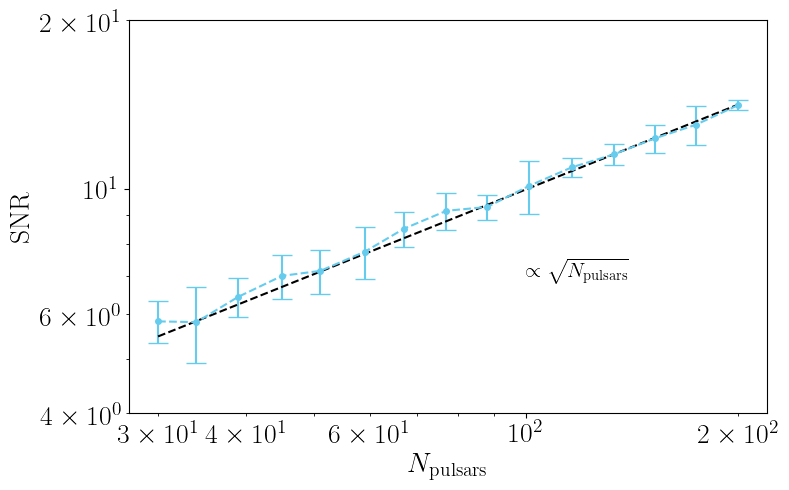

In [ ]:
plt.figure(figsize=(8, 5))

plt.errorbar(
    N_pulsars,
    SNR_mean,
    yerr=SNR_std,
    color=pf.my_colormap["cyan"],
    fmt="o",
    markersize=4,
    linestyle="dashed",
    capsize=7,
)

plt.loglog(
    N_pulsars,
    np.sqrt(N_pulsars),
    linestyle="--",
    color="black",
)

plt.text(1e2, 7, s=r"$\propto \sqrt{N_{\rm pulsars}}$", fontsize=15)
plt.xlabel(r"$N_{\rm pulsars}$", fontsize=20)
plt.ylabel(r"$\rm SNR$", fontsize=20)
plt.ylim(4, 2e1)
plt.tight_layout()
plt.savefig("plots/SNR_N_scaling.pdf")

### - Plot the scaling of uncertainties on the SGWB shape parameters with N_pulsars

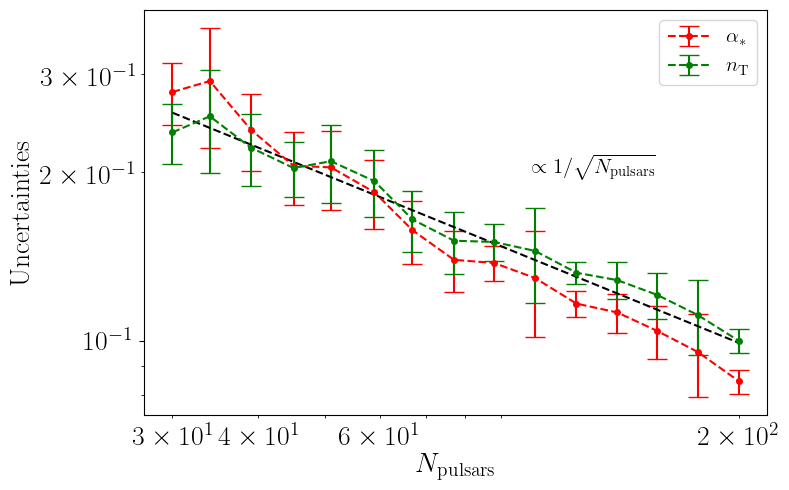

In [ ]:
plt.figure(figsize=(8, 5))
for i in range(len(signal_parameters)):
    colors = list(pf.my_colormap.keys())
    col = colors[np.mod(i, len(colors))]
    plt.errorbar(
        N_pulsars,
        uncertainties_means[:, i],
        yerr=uncertainties_stds[:, i],
        color=col,
        fmt="o",
        markersize=4,
        linestyle="dashed",
        capsize=7,
        label=signal_labels[i],
    )

plt.loglog(
    N_pulsars,
    1.4 / N_pulsars**0.5,
    linestyle="--",
    color="black",
)

plt.text(1e2, 0.2, s=r"$\propto 1/\sqrt{N_{\rm pulsars}}$", fontsize=15)

plt.xticks([], fontsize=20)
plt.xlabel(r"$N_{\rm pulsars}$", fontsize=20)
plt.ylabel(r"$\rm Uncertainties$", fontsize=20)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig("plots/Error_N_scaling.pdf")

### - Plot the scaling of uncertainties on the Legendre polynomials coefficients with N_pulsars

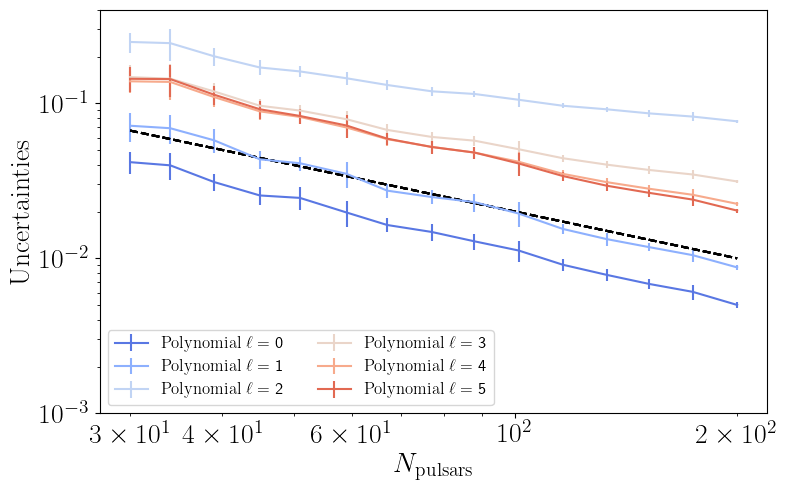

In [ ]:
if HD_order:
    if HD_basis == "Legendre":
        label = r"$\rm Polynomial \ \ell = \ $"
    else:
        label = r"$\rm Bin \ = \ $"
    # here plot scaling of SNR with T_obs
    plt.figure(figsize=(8, 5))
    for i in range(HD_order + 1):
        plt.errorbar(
            N_pulsars,
            uncertainties_means[:, len(signal_parameters) + i],
            yerr=uncertainties_stds[:, len(signal_parameters) + i],
            label=label + str(i),
            color=pf.cmap_HD(0.1 + i / 1.1 / (HD_order + 1)),
        )

        plt.loglog(
            N_pulsars,
            2 / N_pulsars,
            linestyle="--",
            color="black",
        )

    plt.xlabel(r"$N_{\rm pulsars}$")
    plt.ylabel(r"$\rm Uncertainties$")
    plt.ylim(1e-3, 4e-1)
    plt.legend(fontsize=12, ncols=2)
    plt.tight_layout()
    plt.savefig("plots/SNR_N_scaling_HD.pdf")